# Results for Ames from Efficiency paper

### RF
Sensitivity: 0.8233

Specificity: 0.7702

perm_AUC: 0.8

ProbabilityClassifier AUC: 0.87


### SVM
Sensitivity: 0.8118

Specificity: 0.7269

perm_AUC: 0.78

ProbabilityClassifier AUC: 0.84


### k-NN
Sensitivity: 0.8236

Specificity: 0.6715

perm_AUC: 0.75

ProbabilityClassifier AUC: 0.82


In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
from pathlib import Path

# External
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler

# Local
from adad.probability import ProbabilityClassifier
from adad.evaluate import (cumulative_accuracy, permutation_auc,
                           predictiveness_curves, roc_ad,
                           sensitivity_specificity)

In [3]:
#Set parameters
SEED = np.random.randint(1000, 999999)
TREE_ESTIMATORS = 100
C = 100

In [4]:
#Set Classifiers
rfc = RandomForestClassifier(n_estimators=TREE_ESTIMATORS, random_state=SEED)
svc = SVC(C=C, random_state=SEED, probability=True)
k_nn = KNeighborsClassifier(n_neighbors=5)

In [5]:
# Step 1: Load data
PATH_ROOT = Path(os.getcwd()).absolute().parent

file_data = os.path.join(PATH_ROOT, "data", "maccs", "Ames_MACCS.csv")
file_idx_train = os.path.join(PATH_ROOT, "experiments", "cv_indices", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "experiments", "cv_indices", "Ames_cv_test.csv")

In [6]:
data = pd.read_csv(file_data)
idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())

In [7]:
#Split dataset into X and y
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [8]:
#Using one CV split as an example
idx_test_cv1 = idx_test['cv1'].dropna().to_numpy().astype(int)
idx_train_cv1 = idx_train['cv1'].dropna().to_numpy().astype(int)

In [9]:
#Prepare training and testing datasets
X_train, X_test, y_train, y_test = X[idx_train_cv1], X[idx_test_cv1], y[idx_train_cv1], y[idx_test_cv1]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
#Step 2: Train classifier
rfc.fit(X_train, y_train)
svc.fit(X_train, y_train)
k_nn.fit(X_train, y_train)
print(f'Seed used {SEED}')

Seed used 710892


## ProbabilityClassifier for Random Forest

In [11]:
rf_train_acc = rfc.score(X_train, y_train)
rf_test_acc = rfc.score(X_test, y_test)
print("Random Forest Classifier with Probability Classifier")
print("=============================================================")
print(f'[Accuracy] Train: {rf_train_acc*100:.2f}%, test: {rf_test_acc*100:.2f}%\n')

Random Forest Classifier with Probability Classifier
[Accuracy] Train: 99.01%, test: 77.95%



In [12]:
# Step 3: Train App Domains
rf_ad = ProbabilityClassifier(clf=rfc)
rf_ad.fit(X_train)

dist_measure = rf_ad.measure(X_test)
y_pred = rfc.predict(X_test)

### Evaluation without changing dm

In [13]:
# Step 4: Evaluation
sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.803
Specificity: 0.745


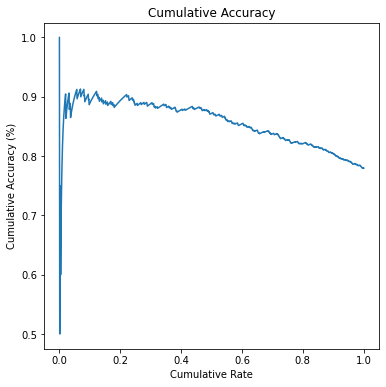

In [14]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

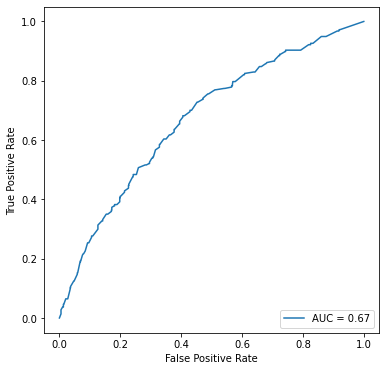

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

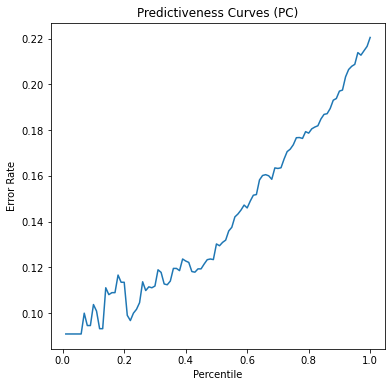

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

In [17]:
print(f"permutationAUC vs auc(roc_ad) of AMES for split1:")
print("====================================================")
print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")

permutationAUC vs auc(roc_ad) of AMES for split1:
         0.608 vs 0.671



### Distance measure with dm+1e-6

In [18]:
# Step 4: Evaluation with dm+1e-6

dm = 1/(dist_measure+1e-6)

sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dm)
fpr, tpr = roc_ad(y_test, y_pred, dm)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dm)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dm)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.803
Specificity: 0.745


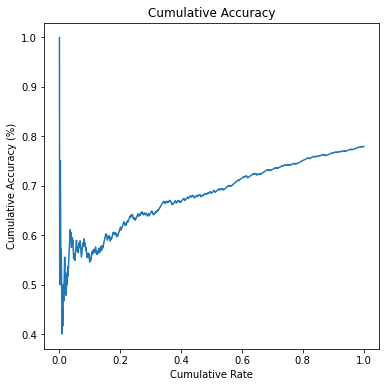

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

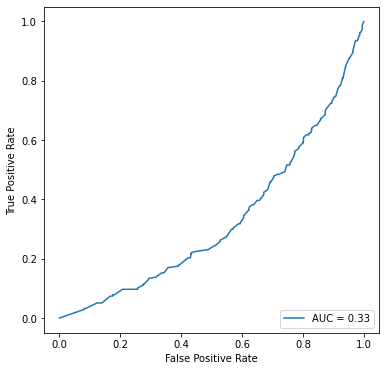

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

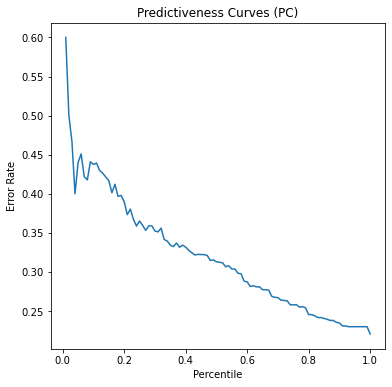

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

In [22]:
print(f"permutationAUC vs auc(roc_ad) of AMES for split1:")
print("====================================================")
print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")

permutationAUC vs auc(roc_ad) of AMES for split1:
         0.441 vs 0.329



## ProbabilityClassifier for Support Vector Machines

In [23]:
svm_train_acc = svc.score(X_train, y_train)
svm_test_acc = svc.score(X_test, y_test)
print("Support Vector Classifier with Probability Classifier")
print("=============================================================")
print(f'[Accuracy] Train: {svm_train_acc*100:.2f}%, test: {svm_test_acc*100:.2f}%\n')

Support Vector Classifier with Probability Classifier
[Accuracy] Train: 96.26%, test: 76.32%



In [24]:
# Step 3: Train App Domain
sv_ad = ProbabilityClassifier(clf=svc)
sv_ad.fit(X_train)

dist_measure = sv_ad.measure(X_test)
y_pred = svc.predict(X_test)

In [25]:
# Step 4: Evaluation
sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.801
Specificity: 0.708


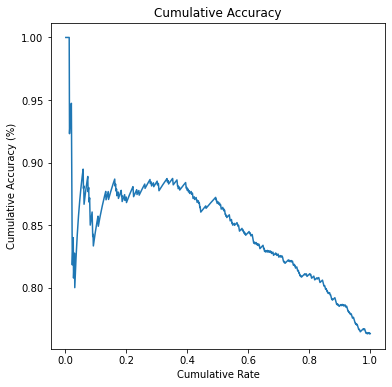

In [26]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

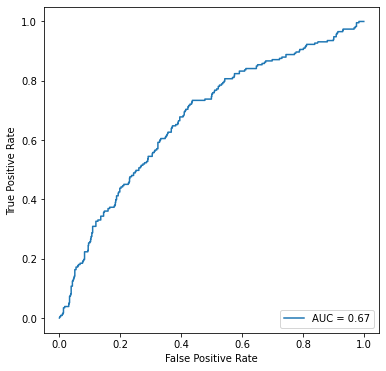

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

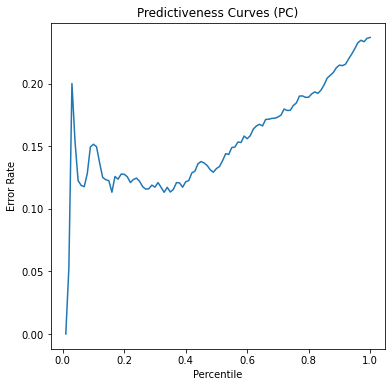

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

In [29]:
print(f"permutationAUC vs auc(roc_ad) of AMES for split1:")
print("====================================================")
print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")

permutationAUC vs auc(roc_ad) of AMES for split1:
         0.559 vs 0.674



## ProbabilityClassifier with K Nearest Neighbors

In [30]:
k_nn_train_acc = k_nn.score(X_train, y_train)
k_nn_test_acc = k_nn.score(X_test, y_test)
print("Support Vector Classifier with Probability Classifier")
print("=============================================================")
print(f'[Accuracy] Train: {k_nn_train_acc*100:.2f}%, test: {k_nn_test_acc*100:.2f}%\n')

Support Vector Classifier with Probability Classifier
[Accuracy] Train: 86.14%, test: 75.61%



In [31]:
# Step 3: Train App Domain
knn_ad = ProbabilityClassifier(clf=k_nn)
knn_ad.fit(X_train)

dist_measure = knn_ad.measure(X_test)
y_pred = k_nn.predict(X_test)

In [32]:
# Step 4: Evaluation
sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.805
Specificity: 0.685


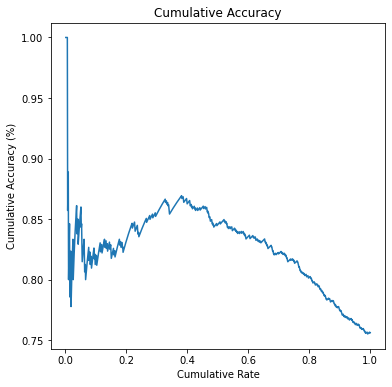

In [33]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

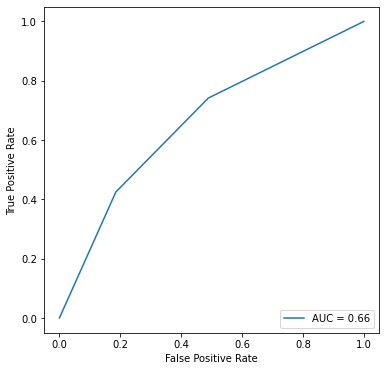

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

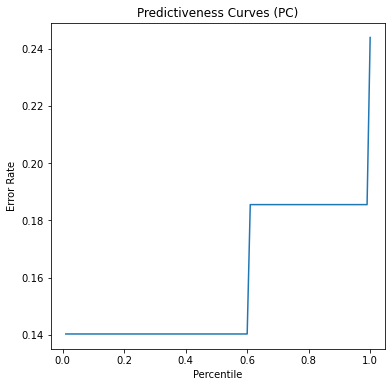

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

## Check all CV Splits and save results

In [36]:
def runAD(dataset, cv_train, cv_test, clf, ad, name, path=None, scale=True):
    #set up ad, scaler, and path
    ad.clf = clf
    scaler = StandardScaler()
    if path == None:
        path = os.getcwd()
    
    #Get X and y
    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, -1].values
    size = X.shape[0]
    
    #Prepare DataFrames for evaluation and score data
    measure = pd.DataFrame()
    evaluation = pd.DataFrame()
    evaluations = []
    
    #Test ad for all cv
    for col in cv_train:
        #Find indexes
        train_idx = cv_train[col].dropna(axis=0).to_numpy().astype(int)
        test_idx = cv_test[col].dropna(axis=0).to_numpy().astype(int)
        
        #Scale train and test datasets
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        if scale:
            
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        #Train AD and classifier
        ad.clf.fit(X_train, y_train)
        ad.fit(X_train)
        
        #Gather scores and save them in csv
        dist_measure = ad.measure(X_test)
        new_col = pd.DataFrame(np.around(dist_measure, decimals=6), columns=[col])
        measure = pd.concat([measure, new_col], axis=1)
        
        #Start gathering data from evaluation functions
        y_pred = ad.clf.predict(X_test)
        
        sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
        cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
        fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
        auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
        percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
        auc_roc = auc(fpr, tpr)
        
        #Compare AUCs
        print(f"permutationAUC vs auc(roc_ad) of {name} for {col}:")
        print("==================================================================")
        print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")
        
        
        #Create graphs to save for each split
        fig, axes = plt.subplots(2,2,figsize=(6,6))
        axes[0, 0].plot(cumulative_rate, cumulative_acc)
        axes[0, 0].set_title("Cumulative Accuracy")
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=auc_roc)
        roc_display.plot(ax=axes[0, 1])
        axes[0, 1].set_title("AUC ROC")
        axes[1, 0].plot(percentile, err_rate)
        axes[1, 0].set_title("Predictiveness Curves (PC)")
        plt.setp(axes[0, 0], xlabel='Cumulative Rate', ylabel='Cumulative Accuracy (%)')
        plt.setp(axes[1, 0], xlabel='Percentile', ylabel='Error Rate')
        fig.delaxes(axes[1, 1])
        fig.suptitle(f'Graphs of {name} for {col}', fontsize=16)
        fig.tight_layout()
        fig.savefig(f'{os.path.join(path, f"{name}_{col}_graphs.png")}', dpi=300)
        
        #Save evaluation
        column1 = pd.DataFrame([np.round(sensitivity, 6)], columns=['sensitivity'])
        column2 = pd.DataFrame([np.round(specificity, 6)],columns=['specificity'])
        column3 = pd.DataFrame(np.around(cumulative_acc, 6),columns=['cumulative_acc'])
        column4 = pd.DataFrame(np.around(cumulative_rate, 6), columns=['cumulative_rate'])
        column5 = pd.DataFrame(np.around(fpr, 6),columns=['roc_ad_fpr'])
        column6 = pd.DataFrame(np.around(tpr, 6),columns=['roc_ad_tpr'])
        column7 = pd.DataFrame([np.round(auc_roc,6)] ,columns=['auc(roc_ad)'])
        column8 = pd.DataFrame([np.round(auc_signi, 6)],columns=['permutation_auc'])
        column9 = pd.DataFrame(np.around(auc_perm,6),columns=['permutation_list'])
        column10 = pd.DataFrame(np.around(percentile, 6),columns=['pred_curve_percent'])
        column11 = pd.DataFrame(np.around(err_rate, 6),columns=['pred_curve_err'])
        
        evaluation = pd.concat([column1, column2, column3, column4, column5, column6, column7, column8, column9, column10, column11],axis=1)
        evaluation.to_csv(os.path.join(path, f'{name}_{col}_evaluation.csv'), index=False)
        evaluations.append(evaluation)
    
    measure.to_csv(os.path.join(path, f'{name}_scores.csv'), index=False)
    
    return evaluations

permutationAUC vs auc(roc_ad) of Ames_rf for cv1:
         0.608 vs 0.671

permutationAUC vs auc(roc_ad) of Ames_rf for cv2:
         0.611 vs 0.714

permutationAUC vs auc(roc_ad) of Ames_rf for cv3:
         0.628 vs 0.730

permutationAUC vs auc(roc_ad) of Ames_rf for cv4:
         0.625 vs 0.699

permutationAUC vs auc(roc_ad) of Ames_rf for cv5:
         0.598 vs 0.708



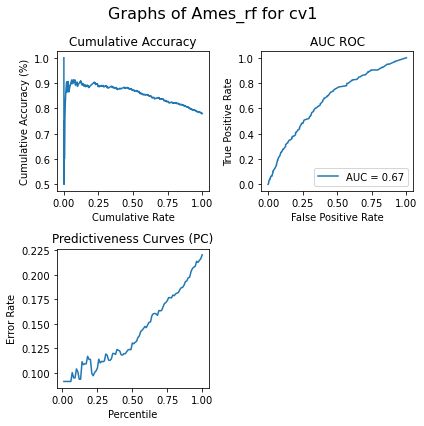

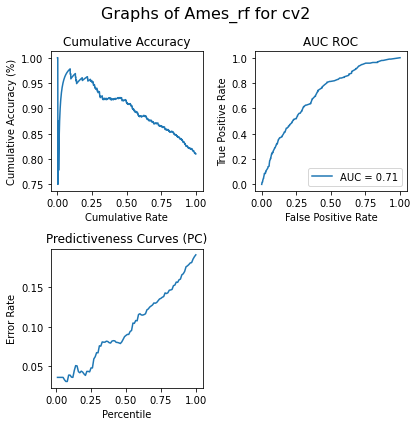

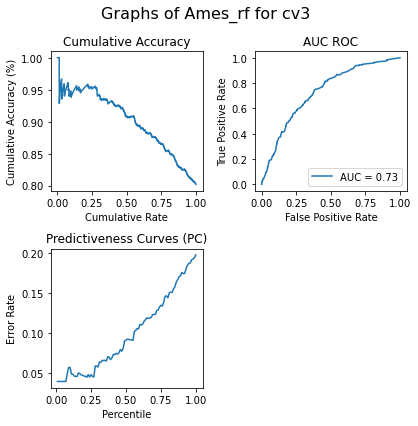

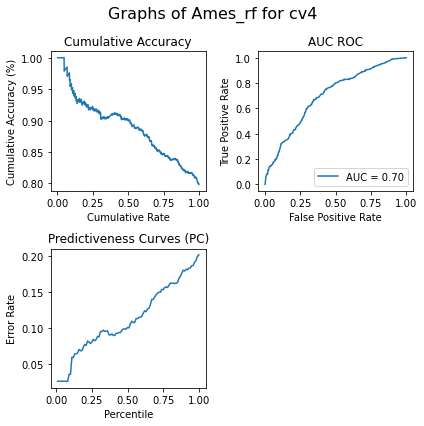

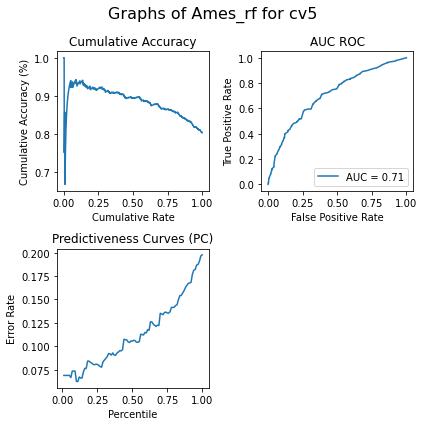

In [37]:
path = os.path.join(PATH_ROOT, 'results')
rf_evaluation = runAD(data, idx_train, idx_test, rfc, rf_ad, "Ames_rf", path)

permutationAUC vs auc(roc_ad) of Ames_svm for cv1:
         0.559 vs 0.674

permutationAUC vs auc(roc_ad) of Ames_svm for cv2:
         0.543 vs 0.676

permutationAUC vs auc(roc_ad) of Ames_svm for cv3:
         0.559 vs 0.722

permutationAUC vs auc(roc_ad) of Ames_svm for cv4:
         0.587 vs 0.699

permutationAUC vs auc(roc_ad) of Ames_svm for cv5:
         0.556 vs 0.702



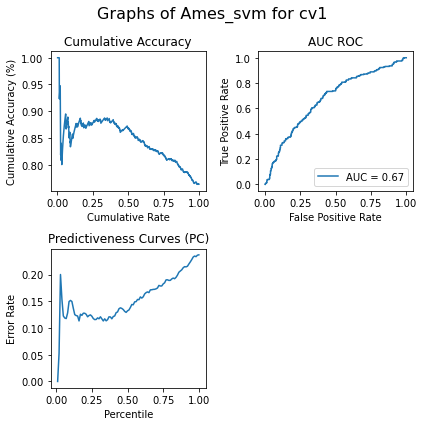

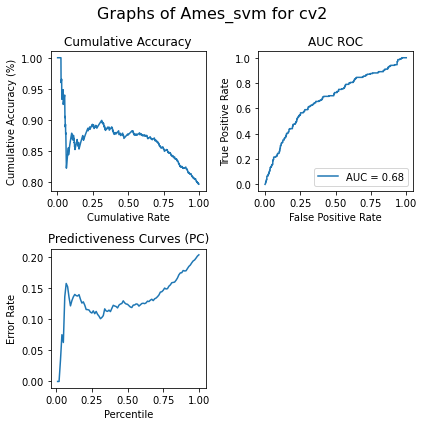

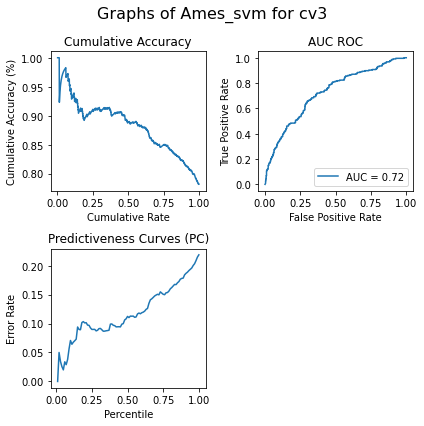

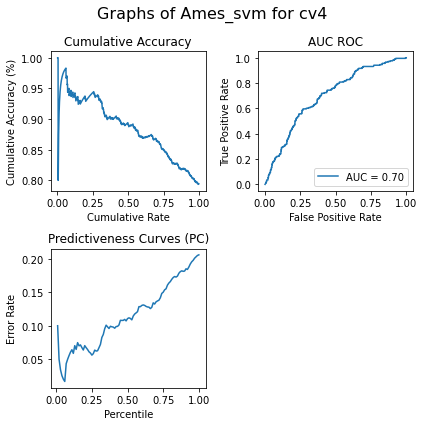

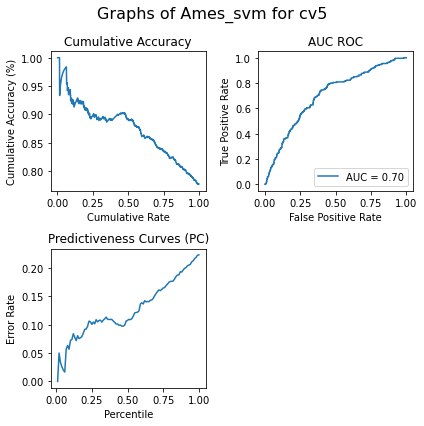

In [38]:
svc_evaluation = runAD(data, idx_train, idx_test, svc, sv_ad, "Ames_svm", path)

permutationAUC vs auc(roc_ad) of Ames_knn for cv1:
         0.567 vs 0.661

permutationAUC vs auc(roc_ad) of Ames_knn for cv2:
         0.545 vs 0.677

permutationAUC vs auc(roc_ad) of Ames_knn for cv3:
         0.567 vs 0.690

permutationAUC vs auc(roc_ad) of Ames_knn for cv4:
         0.572 vs 0.659

permutationAUC vs auc(roc_ad) of Ames_knn for cv5:
         0.554 vs 0.680



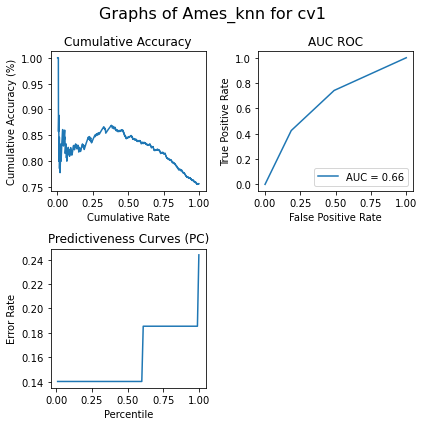

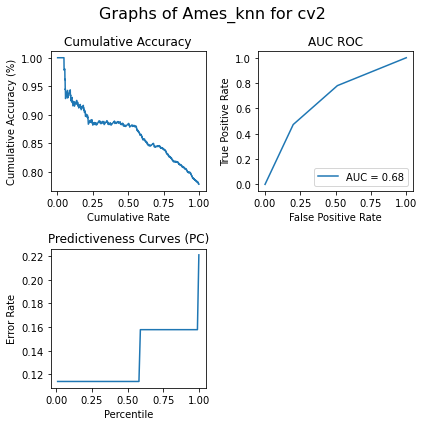

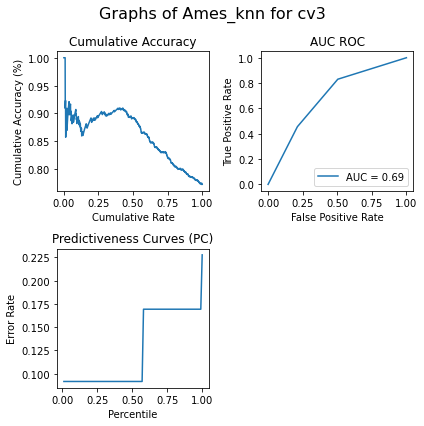

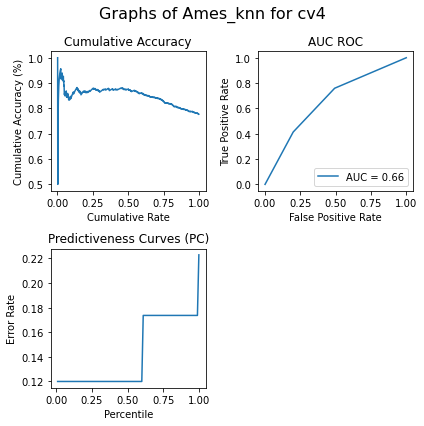

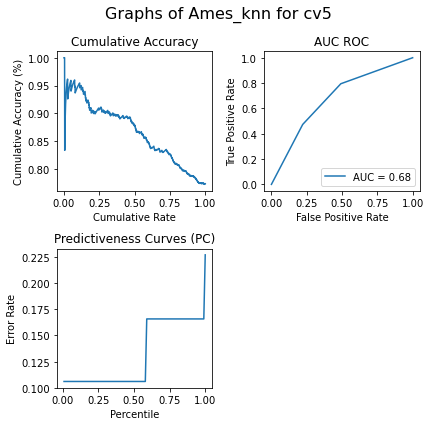

In [39]:
knn_evaluation = runAD(data, idx_train, idx_test, k_nn, knn_ad, "Ames_knn", path)